In [1]:
import sys
sys.path.append('utils')
from nd_tools import (scale_img,
                      get_superpixel_means_as_features, 
                      get_superpixel_stds_as_features,
                      get_array_from_features,
                      get_RAG_neighbors, 
                      apply_func_to_superpixels,
                      get_features_from_array,
                      get_superpixel_area_as_features
                     )
from rio_tools import polygonize_array_to_shapefile, rasterize_shapes_to_array
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from tqdm import tqdm
from sklearn.cluster import KMeans
from skimage.segmentation import felzenszwalb
from skimage.color import label2rgb
from pprint import pprint
import geopandas as gpd
from rasterio import plot
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support as score


The goals of the notebook

+ Show how to ingest shapefiles as labeled data for a supervised classification.
+ Utilize a full time series for classification.

# Inspecting Data

## Image Parameter

There are 8 years we consider 2007, 2008, 2009, 2010, 2015, 2016, 2017, 2018. There are indices 0, 1, ..., 7.

In [2]:
TIMESERIES_INDEX = 0

## Raster Paths


In [3]:
data_dir = Path('data')
rgb_dir = data_dir/'rgb'
rgb_tifs = sorted(list(rgb_dir.glob('*.tif')))
rgb_tifs

[PosixPath('data/rgb/N05E100_07_rgb.tif'),
 PosixPath('data/rgb/N05E100_08_rgb.tif'),
 PosixPath('data/rgb/N05E100_09_rgb.tif'),
 PosixPath('data/rgb/N05E100_10_rgb.tif'),
 PosixPath('data/rgb/N05E100_15_rgb.tif'),
 PosixPath('data/rgb/N05E100_16_rgb.tif'),
 PosixPath('data/rgb/N05E100_17_rgb.tif'),
 PosixPath('data/rgb/N05E100_18_rgb.tif')]

In [4]:
hv_dir = data_dir/'jaxa_mosaics_cropped_tv/hv/'
hv_tifs = sorted(list(hv_dir.glob('*.tif')))
hv_tifs

[PosixPath('data/jaxa_mosaics_cropped_tv/hv/N05E100_07_sl_HV.tif'),
 PosixPath('data/jaxa_mosaics_cropped_tv/hv/N05E100_08_sl_HV.tif'),
 PosixPath('data/jaxa_mosaics_cropped_tv/hv/N05E100_09_sl_HV.tif'),
 PosixPath('data/jaxa_mosaics_cropped_tv/hv/N05E100_10_sl_HV.tif'),
 PosixPath('data/jaxa_mosaics_cropped_tv/hv/N05E100_15_sl_HV.tif'),
 PosixPath('data/jaxa_mosaics_cropped_tv/hv/N05E100_16_sl_HV.tif'),
 PosixPath('data/jaxa_mosaics_cropped_tv/hv/N05E100_17_sl_HV.tif'),
 PosixPath('data/jaxa_mosaics_cropped_tv/hv/N05E100_18_sl_HV.tif')]

In [5]:
hh_dir = data_dir/'jaxa_mosaics_cropped_tv/hh/'
hh_tifs = sorted(list(hh_dir.glob('*.tif')))
hh_tifs

[PosixPath('data/jaxa_mosaics_cropped_tv/hh/N05E100_07_sl_HH.tif'),
 PosixPath('data/jaxa_mosaics_cropped_tv/hh/N05E100_08_sl_HH.tif'),
 PosixPath('data/jaxa_mosaics_cropped_tv/hh/N05E100_09_sl_HH.tif'),
 PosixPath('data/jaxa_mosaics_cropped_tv/hh/N05E100_10_sl_HH.tif'),
 PosixPath('data/jaxa_mosaics_cropped_tv/hh/N05E100_15_sl_HH.tif'),
 PosixPath('data/jaxa_mosaics_cropped_tv/hh/N05E100_16_sl_HH.tif'),
 PosixPath('data/jaxa_mosaics_cropped_tv/hh/N05E100_17_sl_HH.tif'),
 PosixPath('data/jaxa_mosaics_cropped_tv/hh/N05E100_18_sl_HH.tif')]

## Make Output Directory for this Tutorial

In [6]:
out_dir = Path('2_Supervised_Classification')
out_dir.mkdir(exist_ok=True)

## Inspect the Rasters

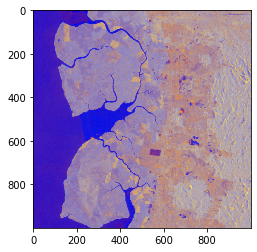

In [7]:
with rasterio.open(rgb_tifs[TIMESERIES_INDEX]) as ds:
    rgb = ds.read().transpose([1, 2, 0])
    profile = ds.profile
plt.imshow(rgb)

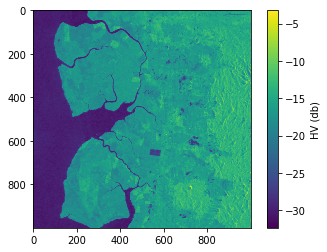

In [8]:
with rasterio.open(hv_tifs[TIMESERIES_INDEX]) as ds:
    hv = ds.read(1)
plt.imshow(hv)
plt.colorbar(label='HV (db)')

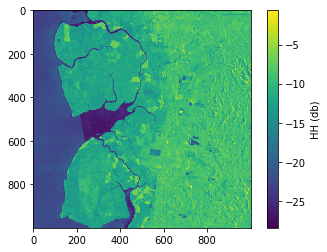

In [9]:
with rasterio.open(hh_tifs[TIMESERIES_INDEX]) as ds:
    hh = ds.read(1)
plt.imshow(hh)
plt.colorbar(label='HH (db)')

# Shapefiles (Labeled Data)

We use [`geopandas`](http://geopandas.org/) to read shapefiles. Each row is a geometric object (in this case a polygon) with varies labeled features (in our case, `class_id` and `class_name`). In other words, each polygon is a label of a particular landcover type.

In [10]:
df_data = gpd.read_file(data_dir/'labels')
df_data.drop(columns='id', inplace=True)
df_data.head()

,class_name,class_id,geometry
0,palm/agriculture,0,"POLYGON ((100.70140 4.62549, 100.70287 4.62799..."
1,forest,1,"POLYGON ((100.76002 4.68010, 100.77023 4.66697..."
2,mangrove,2,"POLYGON ((100.64271 4.70637, 100.64475 4.71133..."
3,water,3,"POLYGON ((100.60740 4.66668, 100.62695 4.66814..."
4,palm/agriculture,0,"POLYGON ((100.67189 4.64158, 100.68123 4.63604..."


For fun, what are these "geometries"?

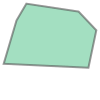

In [11]:
df_data.geometry[0]

In [12]:
type(df_data.geometry[0])

shapely.geometry.polygon.Polygon

They are just the polygons in qgis as [`shapely`](https://shapely.readthedocs.io/en/stable/manual.html) polygons. Shapely is a powerful tool for manipulating planar geometries. It's the engine that helps run `geopandas`. 

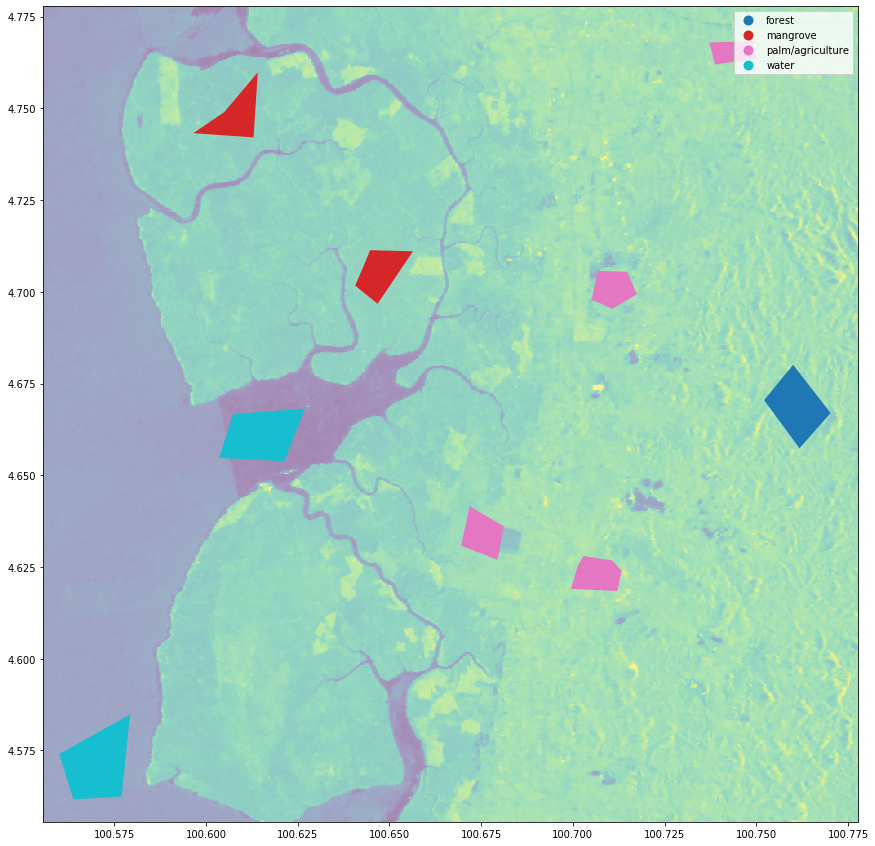

In [13]:
with rasterio.open(rgb_tifs[TIMESERIES_INDEX]) as ds:
    fig, ax = plt.subplots(figsize=(15, 15))
    df_data.plot(ax=ax, column='class_name', legend=True)
    plot.show(ds, ax=ax, alpha=.5)

## Backscatter of Labeled Areas

This is a digression to get statistics within a polygon above. We have to `rasterize` the polygons so they can be understood with respect to our raster data. Fortunately, there is easy ways to do that with rasterio! See this [example](https://gis.stackexchange.com/a/151861) on GIS-stackexchange. We have a function that uses that answer and now slices the data and gets the quartiles, mean, and std.

In [14]:
def aggregate_geometry_on(geo, raster, profile):
    label_mask = rasterize_shapes_to_array([geo], [1], profile, all_touched=True)
    sliced_df = pd.DataFrame({'sliced_data': raster[label_mask == 1]})
    data_dict = (sliced_df.describe().to_dict())['sliced_data']
    return (data_dict)

In [15]:
f_bs_hv = lambda geo: aggregate_geometry_on(geo, hv, profile)
data_bs_hv = pd.DataFrame(list(map(f_bs_hv, df_data.geometry.tolist())))
data_bs_hv.rename(columns={col: f'{col}_bs_hv_db' for col in data_bs_hv.columns}, inplace=True)
data_bs_hv

,count_bs_hv_db,mean_bs_hv_db,std_bs_hv_db,min_bs_hv_db,25%_bs_hv_db,50%_bs_hv_db,75%_bs_hv_db,max_bs_hv_db
0,2139.0,-16.038345,0.831698,-19.662659,-16.526270,-16.127970,-15.639778,-13.099903
1,4298.0,-13.603674,1.477811,-20.583191,-14.461235,-13.587095,-12.788188,-7.865953
2,2649.0,-16.604425,0.399257,-18.548382,-16.837801,-16.596020,-16.339600,-14.979456
3,5108.0,-30.070232,0.330839,-31.894388,-30.271173,-30.067881,-29.863915,-29.004869
4,2249.0,-20.346634,4.170029,-28.241800,-25.546850,-17.850191,-17.145353,-14.930940
5,1939.0,-16.960072,2.285455,-27.010181,-18.003554,-16.596247,-15.506354,-11.596474
6,1372.0,-15.141024,0.703935,-17.881458,-15.570076,-15.038092,-14.670013,-13.037486
7,5988.0,-30.125376,0.278143,-31.550030,-30.293267,-30.113868,-29.946702,-29.155640
8,2722.0,-18.605268,0.832662,-20.433043,-19.223611,-18.724234,-18.083187,-14.153424


Now, let's combine this with our original dataframe.

In [16]:
pd.concat([df_data, data_bs_hv], axis=1)

,class_name,class_id,geometry,count_bs_hv_db,mean_bs_hv_db,std_bs_hv_db,min_bs_hv_db,25%_bs_hv_db,50%_bs_hv_db,75%_bs_hv_db,max_bs_hv_db
0,palm/agriculture,0,"POLYGON ((100.70140 4.62549, 100.70287 4.62799...",2139.0,-16.038345,0.831698,-19.662659,-16.526270,-16.127970,-15.639778,-13.099903
1,forest,1,"POLYGON ((100.76002 4.68010, 100.77023 4.66697...",4298.0,-13.603674,1.477811,-20.583191,-14.461235,-13.587095,-12.788188,-7.865953
2,mangrove,2,"POLYGON ((100.64271 4.70637, 100.64475 4.71133...",2649.0,-16.604425,0.399257,-18.548382,-16.837801,-16.596020,-16.339600,-14.979456
3,water,3,"POLYGON ((100.60740 4.66668, 100.62695 4.66814...",5108.0,-30.070232,0.330839,-31.894388,-30.271173,-30.067881,-29.863915,-29.004869
4,palm/agriculture,0,"POLYGON ((100.67189 4.64158, 100.68123 4.63604...",2249.0,-20.346634,4.170029,-28.241800,-25.546850,-17.850191,-17.145353,-14.930940
5,palm/agriculture,0,"POLYGON ((100.70683 4.70571, 100.71478 4.70547...",1939.0,-16.960072,2.285455,-27.010181,-18.003554,-16.596247,-15.506354,-11.596474
6,palm/agriculture,0,"POLYGON ((100.73718 4.76795, 100.74907 4.76829...",1372.0,-15.141024,0.703935,-17.881458,-15.570076,-15.038092,-14.670013,-13.037486
7,water,3,"POLYGON ((100.56004 4.57401, 100.57934 4.58482...",5988.0,-30.125376,0.278143,-31.550030,-30.293267,-30.113868,-29.946702,-29.155640
8,mangrove,2,"POLYGON ((100.60500 4.74896, 100.61414 4.75980...",2722.0,-18.605268,0.832662,-20.433043,-19.223611,-18.724234,-18.083187,-14.153424


*What do you notice about water backscatter vs. forest backscatter in the labeled polygons?*

# Superpixel Segmentation

The notion of the "superpixel" were first introduced in this [article](https://ttic.uchicago.edu/~xren/publication/xren_iccv03_discrim.pdf) as a way segmenting in an image into small homogeneous areas. Frequently, individual pixel analysis obscures higher level image analysis such as object detection while lowerin the resolution performs unwanted smoothing. Since superpixels were introduced, there have been numerous subsequent algorithms for extracting superpixel segmentations including the [Felzenszwalb algorithm](http://people.cs.uchicago.edu/~pff/papers/seg-ijcv.pdf) which is implemented in skimage and nicely demonstrated [here](https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_segmentations.html). This is the algorithm we use.

For remote sensing, superpixels mitigate noise within a small homogenous image areas particularly for classifcation [1](https://ieeexplore.ieee.org/abstract/document/5593215) [2](https://ieeexplore.ieee.org/abstract/document/6247500). Additionally, they are used in global scale Mangrove extent [3](https://data.unep-wcmc.org/datasets/45) and forest loss [4](https://www.sciencedirect.com/science/article/pii/S0034425714001527).


## Using Skimage

Skimage takes a multichannel image (in this case our RGB composite) and outputs a matrix of labels so that each pixel has a unique integer label.

In [17]:
# Check the documentation and papers above for an explanation of parameters
# We don't use sigma because TV is already denoised
superpixel_labels = felzenszwalb(rgb, 
                                 scale=.5, 
                                 sigma=0, 
                                 min_size=10, 
                                 multichannel=True)
print('superpixels shape: ', superpixel_labels.shape)
print('rgb shape: ', rgb.shape)

superpixels shape:  (1000, 1000)
rgb shape:  (1000, 1000, 3)


We now visualize the array with each segment as a random color.

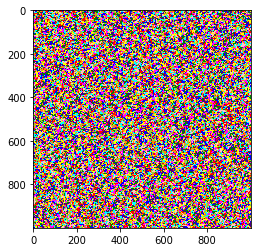

In [18]:
superpixel_labels_viz = label2rgb(superpixel_labels)
plt.imshow(superpixel_labels_viz)

# Viewing Segments in QGIS

To view in QGIS, we use the [`features`](https://rasterio.readthedocs.io/en/stable/api/rasterio.features.html) module from QGIS and [`fiona`](https://github.com/Toblerity/Fiona) to write these vectors to file. We have collected this [answer](https://gis.stackexchange.com/a/187883) from GIS stackexchange into a function.

In [19]:
polygonize_array_to_shapefile(superpixel_labels, profile, out_dir/f'superpixels_{TIMESERIES_INDEX}')

# Extracting Features from Segments

Within a segment we can extract means, variance, medians, etc. We use the [measurement](https://docs.scipy.org/doc/scipy-0.16.0/reference/ndimage.html#module-scipy.ndimage.measurements) module from scipy's ndimage. We have some functions to make their use slightly more straightforward.

In [20]:
std_features = get_superpixel_stds_as_features(superpixel_labels, rgb)
mean_features = get_superpixel_means_as_features(superpixel_labels, rgb)

/Users/cmarshak/anaconda3/envs/sari_test/lib/python3.7/site-packages/scipy/ndimage/measurements.py:523: RuntimeWarning: invalid value encountered in true_divide
  means = sums / counts


We have features $K \times q$ where $K$ are the number of superpixels segments and $q$ are the number of channels. Skimage also ensures that are labels are of the form 0, 1, 2, ... K, so that each index of the mean feature is also its label, which makes subsequent manipulation a bit easier.

In [21]:
print('mean features shape: ', mean_features.shape)
print('Number of labels: ', len(np.unique(superpixel_labels)))

mean features shape:  (32859, 3)
Number of labels:  32859


To retiterate, ($K$ unique labels) $\times$ ($q$ channels). Here $q=3$ as we have an rgb image with three channels.

# Mean Populated Superpixels

We want to create an array corresponding to our map, where every pixel of a particular label is populated with the mean of the superpixel it belongs to. This is accomplished using `get_array_from_features`, which again is a wrapper for [`labeled_comprehension`](https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.ndimage.measurements.labeled_comprehension.html#scipy.ndimage.measurements.labeled_comprehension) from scipy.

In [22]:
mean_arr = get_array_from_features(superpixel_labels, mean_features)
std_arr = get_array_from_features(superpixel_labels, std_features)

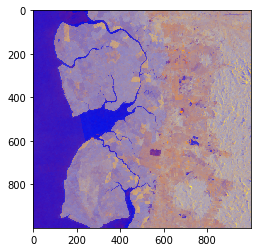

In [23]:
plt.imshow(mean_arr)

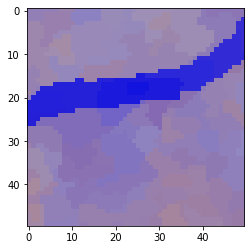

In [24]:
plt.imshow(mean_arr[200:250, 200:250])

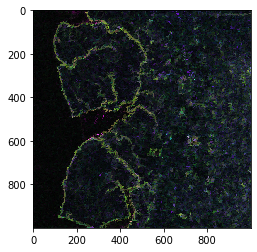

In [25]:
std_arr_viz = std_arr.copy()
for k in range(3):
    std_arr_viz[..., k] = scale_img(std_arr[..., k])
plt.imshow(std_arr_viz, vmin=0)

Let's write this mean array to QGIS.

In [26]:
pprint(profile)

{'count': 3,
 'crs': CRS.from_epsg(4326),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 1000,
 'interleave': 'band',
 'nodata': None,
 'tiled': False,
 'transform': Affine(0.00022222222222222223, 0.0, 100.55555555555556,
       0.0, -0.00022222222222222223, 4.777777777777778),
 'width': 1000}


In [27]:
X = mean_arr.transpose([2, 0, 1])
X = X.astype(np.float32)

with rasterio.open(out_dir/f'mean_superpixels_{TIMESERIES_INDEX}.tif', 'w', **profile) as ds:
    # Transpose is a nice way to change from BSQ to BIP
    ds.write(X)

In [28]:
X = std_arr_viz.transpose([2, 0, 1])
X = X.astype(np.float32)

with rasterio.open(out_dir/f'std_superpixels_{TIMESERIES_INDEX}.tif', 'w', **profile) as ds:
    # Transpose is a nice way to change from BSQ to BIP
    ds.write(X)

# Supervised Classification with Superpixels

Superpixels can improve model output by grouping homogeneous areas together. We now show how to apply sklearn models to the superpixel features. We use the mean features as input.


## Obtaining Training Areas

The polygonal features that we labeled don't precisely fall into superpixels, so anytime a superpixel touches a labeled area, we are going to label it accordingly.

Here are the steps:

1. Get raster of training aras
2. Determine which superpixel labels contain class labels with `np.isin`
3. Split into Train/Validation Sets

### 1 Raster of Labeled Areas

First, we'll gather the relevant data from our dataframe.

In [29]:
label_geometries, class_ids, class_names = (df_data.geometry.tolist(), 
                                            df_data.class_id.tolist(), 
                                            df_data.class_name.tolist())

In [30]:
class_dict = {class_id: class_name for class_id, class_name in zip(class_ids, class_names)}

We are going to rasterize these shapes using the function built on [rasterio.features](https://rasterio.readthedocs.io/en/latest/api/rasterio.features.html) and illustrated [here](https://github.com/mapbox/rasterio/blob/master/docs/topics/features.rst).

In [31]:
# We will use -1 to fill out the rest of the array where the labels aren't present.
class_arr = rasterize_shapes_to_array(label_geometries,
                                      class_ids,
                                      profile,
                                      all_touched=True,
                                      fill_value=-1)

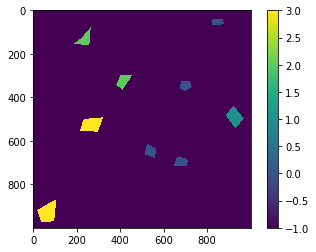

In [32]:
plt.imshow(class_arr)
plt.colorbar()

### 2 Superpixel Features of Labeled Data

Now, we are going to use our superpixel values to train our models (not individual pixels). This means we have to figure out how to transfer the pixel labels above into superpixel features for processing. This is all the slicing of arrays that we now do.

In [33]:
class_ids = sorted(class_dict.keys())
class_names = [class_dict[class_id] for class_id in class_ids]

In [34]:
print(class_names)
print(class_ids)

['palm/agriculture', 'forest', 'mangrove', 'water']
[0, 1, 2, 3]


In [35]:
# Initialize features that indicate label; assuming -1 is no label.
class_features = np.ones((mean_features.shape[0], 1)) * -1
for class_id in class_ids:
    # Get all superpixel labels with particular id
    superpixel_labels_for_class = np.unique(superpixel_labels[class_id == class_arr])
    # Label those superpixels with approrpriate class
    class_features[superpixel_labels_for_class] = class_id

Don't worry, we can still visualize these labels as before. *Why did our label areas expand?*

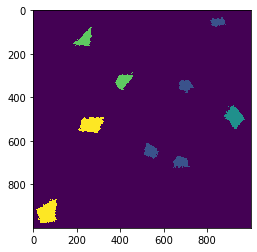

In [36]:
class_arr_superpixels = get_array_from_features(superpixel_labels, class_features)
plt.imshow(class_arr_superpixels)

Now, we obtain the backscatter RGB features from before using our labels.

## Obtaining all features across time series

In [56]:
def get_mean_features(timeseries_index):
    with rasterio.open(rgb_tifs[timeseries_index]) as ds:
        rgb_img = ds.read().transpose([1, 2, 0])
    std_features = get_superpixel_stds_as_features(superpixel_labels, rgb)
    mean_features = get_superpixel_means_as_features(superpixel_labels, rgb_img)
    std_features = get_superpixel_stds_as_features(superpixel_labels, rgb_img)
    return mean_features, std_features

# Going to just use 2007-2010
all_mean_features, all_std_features = zip(*list(map(get_mean_features, tqdm(range(4)))))
all_mean_features = np.concatenate(all_mean_features, axis=1)
all_std_features = np.concatenate(all_std_features, axis=1)

  0%|          | 0/4 [00:00<?, ?it/s]/Users/cmarshak/anaconda3/envs/sari_test/lib/python3.7/site-packages/scipy/ndimage/measurements.py:523: RuntimeWarning: invalid value encountered in true_divide
  means = sums / counts
100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


In [57]:
labeled_feature_indices = (class_features != -1)
labeled_class_features = class_features[labeled_feature_indices]

In [58]:
labeled_mean_features = all_mean_features[labeled_feature_indices.ravel(), :]
labeled_std_features = all_std_features[labeled_feature_indices.ravel(), :]

all_labeled_features = np.concatenate([labeled_mean_features, 
                                       labeled_std_features
                                      ], axis=1)

### 3 Split into Train/Validation Set

Finally, let's split the labeled data into train/validation sets. We are specifying a 25/75 train/test split, though it's arbitrary.

In [59]:
X = all_labeled_features
y = labeled_class_features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [60]:
print('These are the sizes of the train/test sets: ', y_train.shape[0], '/', y_test.shape[0])

These are the sizes of the train/test sets:  907 / 303


# Training our model

We'll evaluate it and use it for mapping, too.

In [61]:
rf = RandomForestClassifier(n_estimators=500,
                            oob_score=True,
                            random_state=0)

In [62]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=True, random_state=0, verbose=0,
                       warm_start=False)

## Some Standard Classification Metrics

Now, we have a model and we can evaluate it on our test (those labeled samples we reserved from before).

In [63]:
y_pred = rf.predict(X_test)

### Confusion Matrix

The [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) is a nice way to measure the performance on the withheld test set.

In [64]:
y_pred_str = pd.Series([class_dict[class_id] for class_id in y_pred], name='Predicted')
y_true_str = pd.Series([class_dict[class_id] for class_id in y_test], name='True')

In [65]:
df = pd.crosstab(y_true_str, y_pred_str)
df

Predicted,forest,mangrove,palm/agriculture,water
True,,,,
forest,53,1,0,0
mangrove,0,48,0,0
palm/agriculture,1,0,77,0
water,0,0,0,123


### Producer/User Accuracy

The [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall) are a common metrics for classifiers, though in remote sensing we refer to the [user/producer accuracies](http://gis.humboldt.edu/OLM/Courses/GSP_216_Online/lesson6-2/metrics.html).

*Intellectual exercise: check (or disprove) the following statement:*

    producer = precision
    user = recall

In [66]:
precision, recall, fscore, support = score(y_pred_str, y_true_str)

In [67]:
index = df.index
df_scores = pd.DataFrame({'Producer': precision,
                          'User': recall,
                         },
                         index = index)
df_scores

,Producer,User
True,,
forest,0.981481,0.981481
mangrove,1.000000,0.979592
palm/agriculture,0.987179,1.000000
water,1.000000,1.000000


## Full Map

Let's use the features across the study area to make a map!

In [68]:
all_features = np.concatenate([all_mean_features,
                               all_std_features
                              ], 
                              axis=1)
features_pred = rf.predict(all_features)
arr_pred = get_array_from_features(superpixel_labels, features_pred.reshape((-1, 1)))

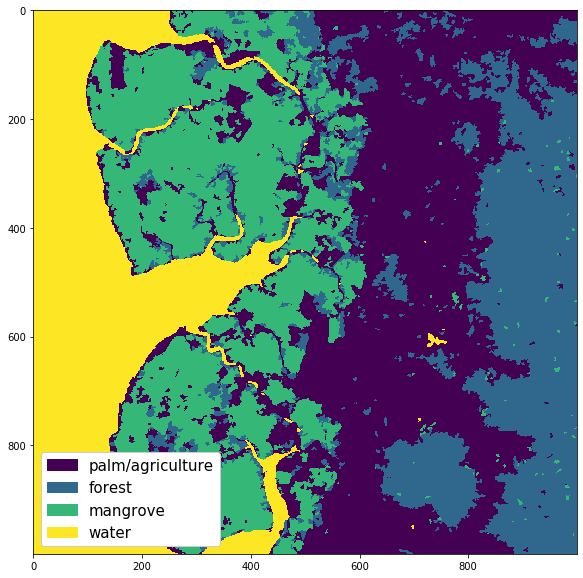

In [69]:
import matplotlib.patches as mpatches

plt.figure(figsize=(10, 10))

im = plt.imshow(arr_pred)
names = [class_dict[class_id] for class_id in class_ids]
values = np.arange(len(names))
# Colors
colors = [im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=colors[i], label=f'{names[i]}') for i in values]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, framealpha=1, fontsize=15, loc='lower left')

## A Majority Filter

We need the so-called "Region-Adjacency Graph" determined by our superpixels.

Here is a visual [example](https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_rag_draw.html) of this graph. Every superpixel is connected to it's neighbor.

In [70]:
# The rag neighbors are key (superpixel_label): value (list of neighbors by superpixel neigbor)
# Assert 0 label is background - this is a scipy artifact - so we add 1 to labels and then subtract from result.
rag_neighbors = get_RAG_neighbors(superpixel_labels+1)
rag_neighbors = {(superpixel_label -1):neighbors-1 for superpixel_label, neighbors in rag_neighbors.items()}

In [71]:
# Returns the most frequent item in list `lst`.
# From: https://stackoverflow.com/a/1518632/2348348
def most_common(lst):
    return max(set(lst), key=lst.count)

features_pred_majority_filter = features_pred.astype(int)
for superpixel_label, neighbor_label_list in tqdm(rag_neighbors.items()):
    if features_pred[superpixel_label] in [0, 1, 2]:
        # We are not going to ignore water as a neigbor
        neighbor_classes = [int(features_pred[label]) 
                            for label in neighbor_label_list if int(features_pred[label]) != 3]
        if neighbor_classes:
            features_pred_majority_filter[superpixel_label] = most_common(neighbor_classes)#[class_label for (_, class_label) in sorted(zip(neighbor_sizes, neighbor_classes))][0]

100%|██████████| 32859/32859 [00:00<00:00, 180883.83it/s]


In [72]:
arr_pred_majority_filter = get_array_from_features(superpixel_labels, 
                                                   features_pred_majority_filter.reshape((-1, 1)))

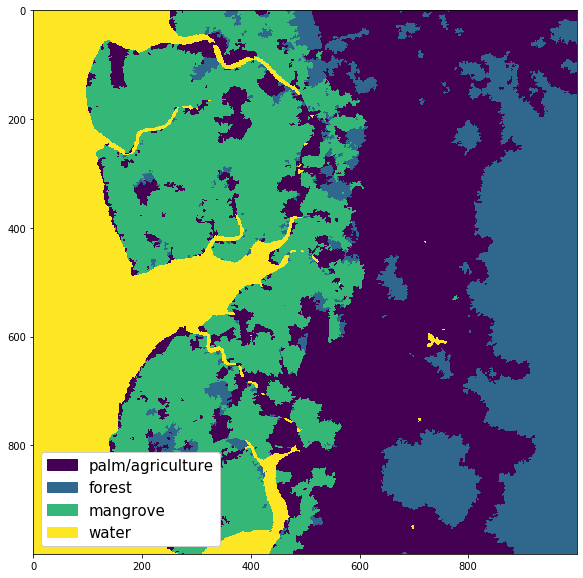

In [73]:
import matplotlib.patches as mpatches

plt.figure(figsize=(10, 10))

im = plt.imshow(arr_pred_majority_filter)
names = [class_dict[class_id] for class_id in class_ids]
values = np.arange(len(names))
# Colors11111
colors = [im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=colors[i], label=f'{names[i]}') for i in values]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, framealpha=1, fontsize=15, loc='lower left')

It looks to be nearly identical on the test set.

Let's save this to a Tiff file.

In [55]:
p = profile.copy()
p['dtype'] = 'uint8'
p['nodata'] = None
p['count'] = 1
with rasterio.open(out_dir/f'classes_pred.tif', 'w', **p) as ds:
    ds.write(arr_pred_majority_filter.astype(np.uint8), 1)

# Acknowledgements

This tutorial was written by Charlie Marshak and supervised closely by [Marc Simard](https://scholar.google.com/citations?user=JQJF1wgAAAAJ&hl=en). 

This tutorial was for the 2019 SARI training [conference](http://sari.umd.edu/meetings/international-regional-science-training) held at Prince of Songkla University, Phuket Campus. We are grateful to the conference organizers [Krishna Vadrevu](https://geog.umd.edu/facultyprofile/vadrevu/krishna) and [Werapong Koedsin](http://werapong-g.space.psu.ac.th/). We also thank the [SARI](http://sari.umd.edu/) and [LCLUC](https://lcluc.umd.edu/) programs, especially [Garik Gutman](https://lcluc.umd.edu/people/garik-gutman), making such trainings possible. We are grateful for the input from and helpful conversations with [Michael Denbina](https://www.researchgate.net/profile/Michael_Denbina), [Tien-Hao Liao](https://scienceandtechnology.jpl.nasa.gov/tien-hao-liao), and Neda Kasraee. 

We gratefully and humbly acknowledge JAXA for the use of ALOS-2 data to generate a coherence image over Mondah, Gabon generated using ISCE2. We are also grateful to the ASF for providing easy access to ALOS-1 radiometrically and terrain corrected tiles over Mondah and Ko Panyi.

A portion of this research was performed at the Jet Propulsion Laboratory, California Institute of Technology. 

Copyright 2019 by the California Institute of Technology. ALL RIGHTS RESERVED. United States Government Sponsorship acknowledged. Any commercial use must be negotiated with the Office of Technology Transfer at the California Institute of Technology.

This software may be subject to U.S. export control laws. By accepting this software, the user agrees to comply with all applicable U.S. export laws and regulations. User has the responsibility to obtain export licenses, or other export authority as may be required before exporting such information to foreign countries or providing access to foreign persons.
